Here we are going to learn the oscillating behaviour from time-series data using neural network.

In [1]:
import sys
sys.path.append("./source")

import pickle
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from generate_dataset import generate_dataset
from train_classic import train_classic
from compute_error import compute_error
from predict_classic import predict_integrate

# 1. Data Preparation

As usual we will create pairs of features and targets (numerical derivatives) from time-series data.

In [2]:
# load data
with open('./data/cell_cycle.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    
data_array = data_dict['data']
time_points = data_dict['t']

# create the dataframe with strain as index

df = pd.DataFrame(data_array.numpy()[0])
df.columns = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
df['Strain'] = [0] * df.shape[0]
df = df.set_index('Strain')
df['Time'] = time_points
df.head()

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC,Time
Strain,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
0,0.185745,0.008765,0.000595,0.000012,0.000006,0.970310,0.993761,0.2
0,0.345694,0.030825,0.004259,0.000085,0.000043,0.940683,0.991450,0.4
0,0.483463,0.061154,0.012881,0.000260,0.000133,0.911164,0.990087,0.6
0,0.602154,0.096144,0.027416,0.000560,0.000285,0.881781,0.989058,0.8


In [3]:
df.shape

(7500, 8)

In [4]:
# now generate and augment the training dataset

feature_list = [] # here we do not have external time-series or control variables
target_list = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
df_train = generate_dataset(df, [0],feature_list, target_list, n_dim=7500)
display(df_train)

feature    target   feature    target   feature    target  \
                 cyclin    cyclin       MPF       MPF    preMPF    preMPF   
Strain Time                                                                 
0      0.0     0.003005  0.898144 -0.003425  0.079749  0.000862 -0.006695   
       0.2     0.182610  0.849663  0.012522  0.093314 -0.000477  0.006907   
       0.4     0.342825  0.752702  0.033895  0.120443  0.003625  0.034111   
       0.6     0.483650  0.648810  0.060693  0.154785  0.013166  0.059963   
       0.8     0.602314  0.552382  0.095801  0.180759  0.027607  0.087821   
...                 ...       ...       ...       ...       ...       ...   
       1499.0  1.998806  0.025684  3.987817  0.203401  5.824301  0.339751   
       1499.2  2.003932  0.025581  4.028745  0.205961  5.892361  0.340860   
       1499.4  2.009038  0.025479  4.070191  0.208535  5.960627  0.341928   
       1499.6  2.014122  0.025376  4.112148  0.211095  6.029114  0.343036   
       1499.8  2.019187  0.025325  4.154617  0.212375  6.097823  0.343590   

                feature    target   feature    target   feature    target  \
                 cdc25P    cdc25P     wee1P     wee1P       IEP       IEP   
Strain Time                                                                 
0      0.0     0.000021 -0.000169  0.000011 -0.000086  1.000026 -0.148749   
       0.2    -0.000013  0.000119 -0.000007  0.000061  0.970280 -0.148432   
       0.4     0.000069  0.000697  0.000035  0.000355  0.940661 -0.147797   
       0.6     0.000266  0.001237  0.000135  0.000631  0.911169 -0.147211   
       0.8     0.000563  0.001827  0.000287  0.000932  0.881784 -0.146563   
...                 ...       ...       ...       ...       ...       ...   
       1499.0  3.937864 -0.006855  0.363066  0.004398  0.010790  0.001109   
       1499.2  3.936569 -0.006089  0.363970  0.004640  0.011015  0.001146   
       1499.4  3.935429 -0.005320  0.364922  0.004882  0.011248  0.001185   
       1499.6  3.934441 -0.004555  0.365922  0.005125  0.011489  0.001222   
       1499.8  3.933607 -0.004172  0.366971  0.005246  0.011737  0.001241   

                feature    target  
                    APC       APC  
Strain Time                        
0      0.0     0.998996 -0.019489  
       0.2     0.995099 -0.017445  
       0.4     0.992019 -0.013358  
       0.6     0.989757 -0.007581  
       0.8     0.988987 -0.004098  
...                 ...       ...  
       1499.0  0.128617 -0.013430  
       1499.2  0.125962 -0.013132  
       1499.4  0.123365 -0.012835  
       1499.6  0.120828 -0.012536  
       1499.8  0.118351 -0.012387  

[7500 rows x 14 columns]

# 2. Training

Now let's do two things: Random Forest and Neural Network

In [6]:
# create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)

# create a pipeline 
nn_model = Pipeline([('Scaler',StandardScaler()),
                            ('neural_net',MLPRegressor(hidden_layer_sizes=(10, 10, 10),
                                                       learning_rate_init=0.1,
                                                       learning_rate='adaptive',
                                                       solver='adam',
                                                       activation='tanh',
                                                       max_iter=1000))])

cyclin


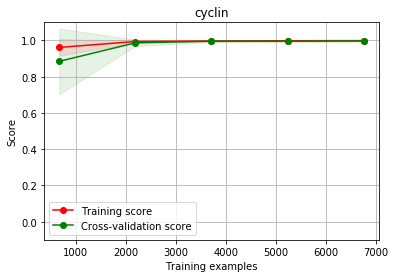

Target: cyclin, CV Pearson R2 coefficient: 0.999874
MPF


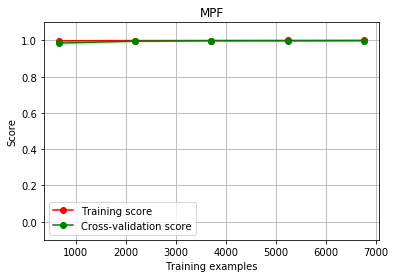

Target: MPF, CV Pearson R2 coefficient: 0.999969
preMPF


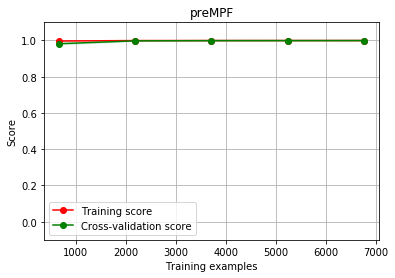

Target: preMPF, CV Pearson R2 coefficient: 0.999817
cdc25P


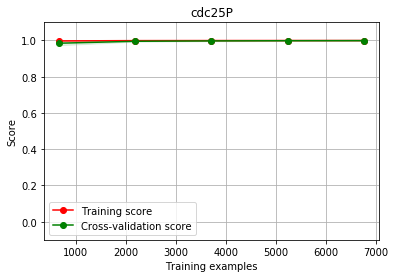

Target: cdc25P, CV Pearson R2 coefficient: 0.999910
wee1P


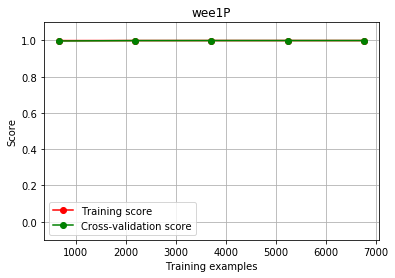

Target: wee1P, CV Pearson R2 coefficient: 0.999878
IEP


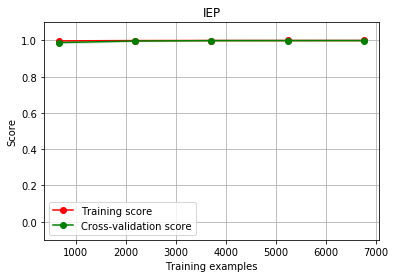

Target: IEP, CV Pearson R2 coefficient: 0.999950
APC


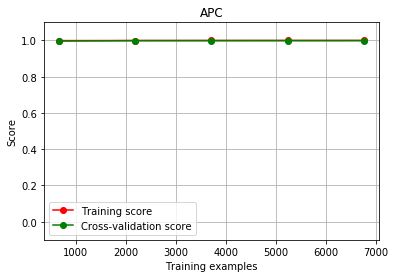

Target: APC, CV Pearson R2 coefficient: 0.999975
Average training score: 0.9999103879664475


In [7]:
figure_path = './plots/'

# train a model
rf_dict, score_dict = train_classic(df_train, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)

cyclin RMSE: 5.172508724629818e-06 standard deviation: 0.00045945715868280916


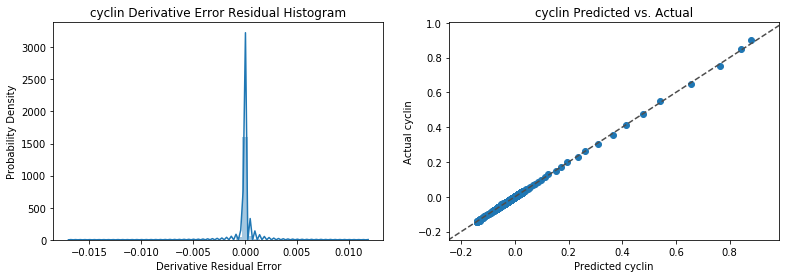

MPF RMSE: -6.856424423184875e-05 standard deviation: 0.0020521105958112053


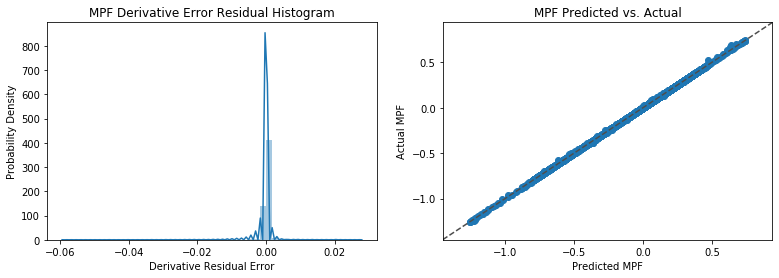

preMPF RMSE: 4.386298158174695e-05 standard deviation: 0.004660306748679654


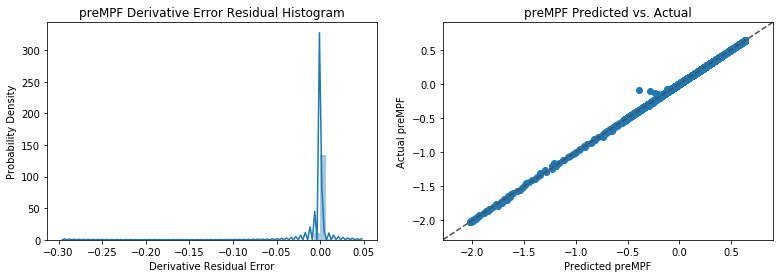

cdc25P RMSE: -1.9228871111380298e-05 standard deviation: 0.0004027307718912535


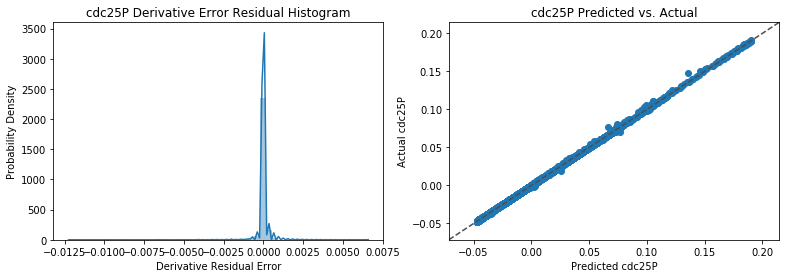

wee1P RMSE: 2.475105189307807e-06 standard deviation: 0.00014813941043608796


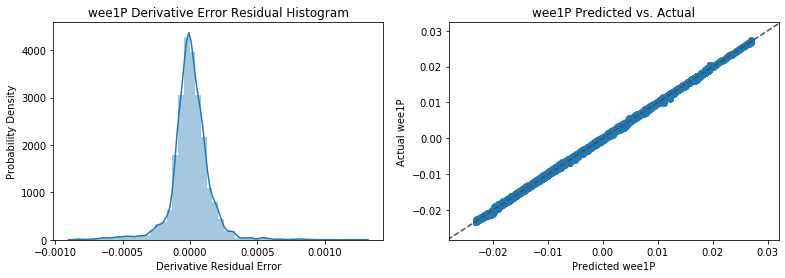

IEP RMSE: -8.899164058541948e-07 standard deviation: 0.00030189159259604


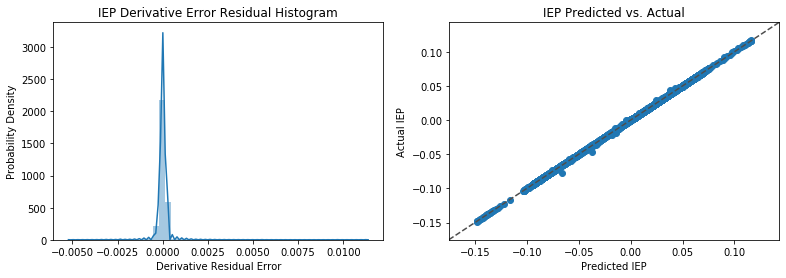

APC RMSE: -5.243939492263584e-06 standard deviation: 0.0001649956669830414


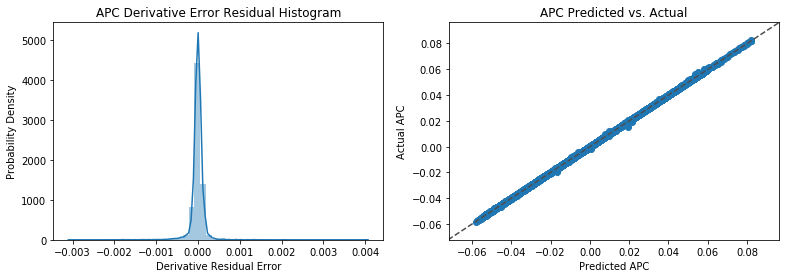

Total Derivative Mean Error: 0.8605032596380625 Error Standard Deviation: 0.01698102916890891


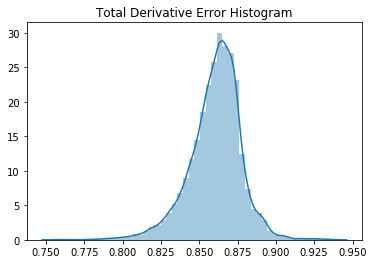

In [8]:
# generate reports on the residual errors
compute_error(df_train,rf_dict,plot=True,model_type='random_forest')

Real data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Strain,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
0,0.185745,0.008765,0.000595,0.000012,0.000006,0.970310,0.993761
0,0.345694,0.030825,0.004259,0.000085,0.000043,0.940683,0.991450
0,0.483463,0.061154,0.012881,0.000260,0.000133,0.911164,0.990087
0,0.602154,0.096144,0.027416,0.000560,0.000285,0.881781,0.989058
...,...,...,...,...,...,...,...
0,1.998806,3.987818,5.824301,3.937864,0.363066,0.010790,0.128617
0,2.003932,4.028746,5.892361,3.936569,0.363970,0.011015,0.125962
0,2.009037,4.070185,5.960643,3.935427,0.364922,0.011248,0.123366


Predicted data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Time,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
0.2,0.172340,0.013956,0.002430,0.000031,0.000038,0.970319,0.996707
0.4,0.333295,0.031120,0.007957,0.000148,0.000085,0.940680,0.993891
0.6,0.474355,0.055710,0.017122,0.000329,0.000152,0.911141,0.991767
0.8,0.599411,0.088185,0.030176,0.000567,0.000263,0.881754,0.990351
...,...,...,...,...,...,...,...
1499.0,1.704945,-334.529051,-1611.850350,1.070543,0.608002,-17.295695,6.771362
1499.2,1.761931,-334.577256,-1612.068869,1.070153,0.608196,-17.298094,6.765689
1499.4,1.818917,-334.625461,-1612.287794,1.069764,0.608385,-17.300494,6.760818


./source/predict_classic.py:216: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_classic.py:221: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: cyclin 19.54950955626061 RMSE percentage: 46.18676036922839


./source/predict_classic.py:221: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: MPF 7411.601886381939 RMSE percentage: 625.580552635713
ML Fit: preMPF 35345.15808262035 RMSE percentage: 1374.9609943947573
ML Fit: cdc25P 109.40879402970161 RMSE percentage: 77.84330597211314
ML Fit: wee1P 7.403696753712641 RMSE percentage: 61.3238281007544
ML Fit: IEP 383.3833199913826 RMSE percentage: 2368.1211360217803
ML Fit: APC 239.03201302786877 RMSE percentage: 593.6149239048785
ML model aggregate error
Average RMSE: 6216.5053289087455
Total percentage error: 735.3759287713178


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


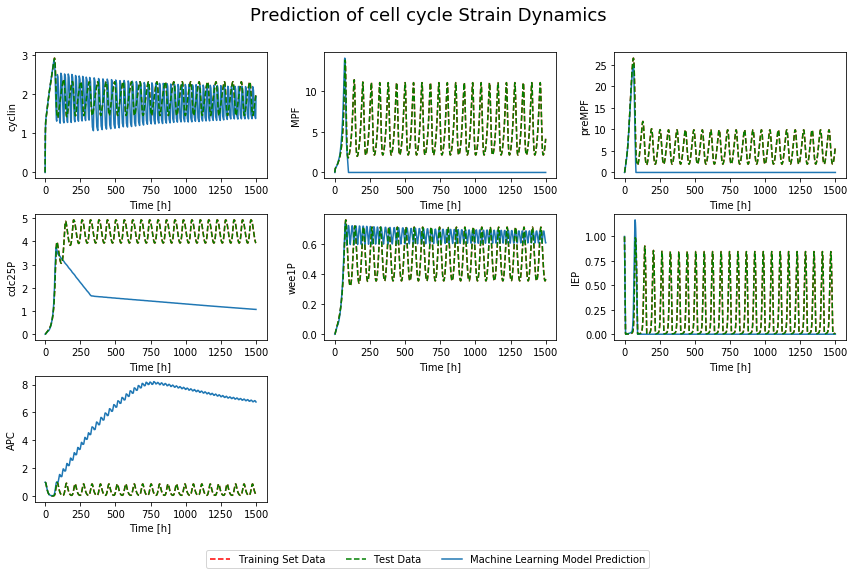

TypeError: cannot unpack non-iterable NoneType object

In [10]:
# now we make predictions via numerical integration
# note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe

time_points, predictions = predict_integrate(df, df, rf_dict, target_list, feature_list, title='cell cycle', plot=True,model_type='random_forest')

In [11]:
plt.plot()

In [17]:
covid19 = {'data': covid19_data, 'pred':covid19_pred, 't':time_points}

with open('covid19.pkl', 'wb') as file:
    pickle.dump(covid19, file)

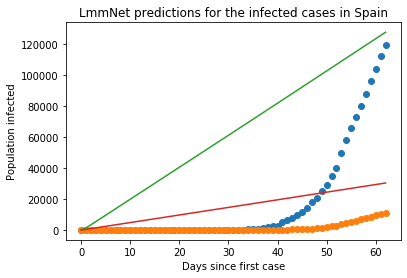

In [6]:
import matplotlib.pyplot as plt
import pickle

with open('covid19.pkl', 'rb') as file:
    covid19 = pickle.load(file)

covid19_data = covid19['data'].reshape(-1,2)
covid19_pred = covid19['pred']
time_points = range(len(covid19_data))
plt.plot(time_points, covid19_data, 'o')
plt.plot(time_points, covid19_pred)
plt.title("LmmNet predictions for the infected cases in " + 'Spain')
plt.ylabel("Population infected")
plt.xlabel("Days since first case")
plt.show()